## CSCE 676 :: Data Mining and Analysis :: Texas A&M University :: Spring 2022


# Homework 1: Let's GOOOOO!

- **100 points [7% of your final grade]**
- **Due Tuesday, February 13 by 11:59pm**

***Goals of this homework:***
1. Collect data from the web, clean it, and then make some observations based on exploratory data analysis
2. Understand and implement the classic apriori algorithm and extensions to find the association rules in a movie rating dataset

***Submission instructions:***

You should post your notebook to Canvas (look for the homework 1 assignment there). Please name your submission **your-uin_hw1.ipynb**, so for example, my submission would be something like **555001234_hw1.ipynb**. Your notebook should be fully executed when you submit ... so run all the cells for us so we can see the output, then submit that. 

***Late Days:***

As a reminder, you may use up to three of your late days on this homework, meaning the latest we will accept it is February 16 by 11:59pm.

***Collaboration declaration:***

If you worked with someone on this homework, please be sure to mention that. Remember to include citations to any sources you use in the homework.

## (50 points) Part 1: UFOs

### (10pts) Part 1a: UFOs are Out There, But First I Need to Store them Locally

For this first part, we're going to collect evidence of UFO sightings from the **National UFO Reporting Center**. Specifically, we're going 
to focus only on UFO sightings in Texas, as reported at this webpage:

* http://www.nuforc.org/webreports/ndxlTX.html

Recall that you can view the source of a webpage in Chrome under View &rarr; Developer &rarr; View Source. 
You'll notice, however, that this raw HTML is not in our friendly csv format and so will require some initial pre-processing. 
In particular, we're going to use the Python libraries **[requests](http://docs.python-requests.org/en/master/)** 
and **[beautiful soup](https://www.crummy.com/software/BeautifulSoup/)** to convert this UFO data from its original HTML format into csv. 

Hints:
* You'll notice that the column headers are in the `<TH>` tags.
* The values are in the `<TD>` tags.
* In beautiful soup, something like `.find_all('td')` may help you.
* To write the csv, you might want to `import csv` and take a look at the functions provided.
* If you google for "beautifulsoup table to csv" you should find some nice starting points.  Note, however, that you may not use an existing method that auto-magically converts the HTML into csv; we expect you to write your own code. If you borrow some elements from online resources, you should cite them in the comments. 

In [113]:
# your code here
# you should use requests to get the webpage, then extract 
# the appropriate column headings and rows
# then write this out to csv to a local file called 'ufos_in_texas.csv'

import requests
import csv
from bs4 import BeautifulSoup

url="http://www.nuforc.org/webreports/ndxlTX.html"

#http = urllib3.PoolManager()

#get request will respond with the html content of url
output = requests.get(url)

#beautifulsoup will fetch and parse the data
output = BeautifulSoup(output.text, 'html.parser')
table = output.find("table")

#get the appropritate rows and column headers from the tr td and tf tags of html table
output_rows =[]
column_headings = []

for column in table.findAll('th'):
  column_headings.append(column.text)

print(column_headings)

for row_table in table.findAll('tr'):

  row_output = {}
  for td,th in zip(row_table.findAll("td"),column_headings) :
    row_output[th] = td.text
  output_rows.append(row_output)

print(output_rows)

#write the data into csv file by simply iterating into it
with open('texasufodata.csv','w') as csvfile:
  writer = csv.DictWriter(csvfile,column_headings)
  writer.writeheader()
  for row in output_rows :
    if row:
      writer.writerow(row)


#CITATIONS
#https://www.kite.com/python/examples/4420/beautifulsoup-parse-an-html-table-and-write-to-a-csv (PARSING THE DATA)
#https://www.pluralsight.com/guides/extracting-data-html-beautifulsoup (FOR WRITING CSV FILE)






['Date / Time', 'City', 'State', 'Shape', 'Duration', 'Summary', 'Posted']
[{}, {'Date / Time': '12/14/21 22:30', 'City': 'Dallas', 'State': 'TX', 'Shape': 'Formation', 'Duration': '8 minutes', 'Summary': 'It was loud like rocket in a V shape.', 'Posted': '12/19/21'}, {'Date / Time': '12/12/21 17:30', 'City': 'Dallas', 'State': 'TX', 'Shape': 'Light', 'Duration': '10 minutes', 'Summary': 'A light that was fading in and out.', 'Posted': '12/19/21'}, {'Date / Time': '12/9/21 16:30', 'City': 'Lazerbet', 'State': 'TX', 'Shape': 'Other', 'Duration': 'Google maping', 'Summary': "It's big", 'Posted': '12/19/21'}, {'Date / Time': '12/9/21 16:00', 'City': 'Lazerbet', 'State': 'TX', 'Shape': 'Triangle', 'Duration': '', 'Summary': 'Unhuman', 'Posted': '12/19/21'}, {'Date / Time': '12/7/21 17:30', 'City': 'Oak Cliff', 'State': 'TX', 'Shape': 'Unknown', 'Duration': '', 'Summary': 'I was randomly taking pictures of the clouds and in 2 frames is a unidentifiable object , all shots were took within th

Once you have your local csv file, you should read it in and then issue the .head() command.

In [114]:
import pandas as pd
txufo = pd.read_csv("texasufodata.csv")
txufo.head()


,Date / Time,City,State,Shape,Duration,Summary,Posted
0,12/14/21 22:30,Dallas,TX,Formation,8 minutes,It was loud like rocket in a V shape.,12/19/21
1,12/12/21 17:30,Dallas,TX,Light,10 minutes,A light that was fading in and out.,12/19/21
2,12/9/21 16:30,Lazerbet,TX,Other,Google maping,It's big,12/19/21
3,12/9/21 16:00,Lazerbet,TX,Triangle,NaN,Unhuman,12/19/21
4,12/7/21 17:30,Oak Cliff,TX,Unknown,NaN,I was randomly taking pictures of the clouds a...,12/19/21


### (15pts) Part 1b: UFOs are a Mess! Time to Clean Up!

Okay, now we move to the fun part -- making sense of this messy data. These UFO reports are user-generated with little input validation. As a result, you will notice lots of oddities. 

Let's begin by focusing on the **Duration** column. As a first pass, let's make a grossly simplifying assumption -- that the only valid data is any duration that is of the form:  

* 1 second
* 2 seconds
* ...
* 1 minute
* 2 minutes
* ...
* 1 hour
* 2 hours 
* ...
* 1 day
* 2 days 
* ...

That is, we will only accept positive integers followed by a space, followed by a properly spelled unit. Every other entry is invalid. For example, that means these are all invalid durations:

* 1s
* 2 min.
* 2-3 seconds
* 10-15min
* 1 minute+
* 30 minutes and longer
* about 1.5 minutes

You may find the **pandas** library to be very helpful for this part. Create a new pandas dataframe that only includes sightings with these values, **where you convert all durations into seconds**. How many total rows are there in the original dataset? How many rows in your new 'validated' dataset? Report the basic statistics of the duration in your new 'validated' dataset (report maximum, minimum, mean, and standard deviation values of duration). At last, plot a boxplot of the duration (in seconds) in your 'validated' dataset.

In [115]:
# your code here 
# filter our invalid durations
# convert all valid durations to seconds

import re

#/d includes all numbers starting from 0-9
#/s includes charecter with single space or more than single space
#Followed by numeral and space, incliude all the possible durations

pattern = '^(\d+\s+(second|seconds|minute|minutes|hour|hours|day|days|week|weeks|month|months|year|years))$'

txufo1 = txufo.loc[txufo['Duration'].str.match(pattern, na = False,flags = re.I)]
units = []
for i, row in txufo1.iterrows():
  row = txufo1['Duration'][i]
  splitd = row.lower().split()
  val = int(splitd[0])
  if(splitd[1] == "minute" or splitd[1] == "minutes"): #convert minute to seconds
    val = val * 60
  elif(splitd[1] == "hour" or splitd[1] == "hours"):   #convert hours to seconds
    val = val * 3600
  elif(splitd[1] == "day" or splitd[1] == "days"):     #convert days to seconds
    val = val * 24 * 3600
  elif(splitd[1] == "week" or splitd[1] == "weeks"):   #convert weeks to seconds
    val = val * 7 * 24 * 3600
  elif(splitd[1] == "month" or splitd[1] == "months"): #convert months to seconds
    val = val * 30 * 24 * 3600
  elif(splitd[1] == "year" or splitd[1] == "years"):   #convert years to seconds
    val = val * 365 * 30 * 24 * 3600
  
  units.append(val)



#citations : https://docs.python.org/3/library/re.html




In [116]:
print(units)

[480, 600, 4730400000, 1800, 2400, 25200, 120, 900, 45, 12, 6, 300, 300, 180, 120, 10800, 30, 60, 8, 600, 7, 1200, 1800, 8, 60, 120, 5, 60, 28800, 30, 180, 600, 300, 15, 45, 240, 6, 60, 120, 15, 900, 120, 300, 900, 60, 10, 120, 120, 30, 8, 900, 900, 2, 240, 5, 2, 60, 300, 3, 300, 300, 10, 30, 420, 1200, 1200, 1200, 10800, 25200, 300, 300, 120, 540, 20, 10, 7200, 600, 14400, 30, 7, 30, 30, 20, 5, 600, 30, 15, 3600, 10, 60, 7, 15, 120, 420, 60, 60, 300, 60, 600, 1200, 300, 3, 5, 8, 3, 35, 2100, 1500, 4, 60, 900, 3600, 10800, 300, 360, 10, 1800, 1200, 60, 120, 600, 60, 5, 30, 360, 720, 600, 180, 5, 30, 10, 1200, 1320, 60, 60, 60, 3600, 60, 5, 60, 7200, 180, 10, 540, 5, 1800, 60, 120, 600, 900, 120, 120, 180, 1800, 600, 60, 45, 900, 240, 120, 120, 10, 600, 120, 240, 600, 180, 1200, 900, 900, 300, 15, 480, 480, 1800, 900, 600, 3600, 1200, 35, 5, 5, 900, 300, 3, 600, 2700, 3600, 480, 30, 120, 5, 900, 600, 1200, 15, 2700, 180, 30, 10, 2700, 1200, 900, 3600, 120, 900, 900, 180, 120, 45, 300, 9

In [117]:
# your code here
# total rows in original dataset
# valid rows in your new 'validated' dataset

total_rows = txufo.shape[0]
print("The total rows in original dataset is ",total_rows )
valid_rows = txufo1.shape[0]
print("The total rows in validated dataset is ",valid_rows )


The total rows in original dataset is  5631
The total rows in validated dataset is  2956


Max value of duration in (s) is : 4730400000
Min value of duration in (s) is : 1
Mean value of duration in (s) is : 1601847.9340324763
Standard Deviation of duration in (s) is : 86990543.03628969


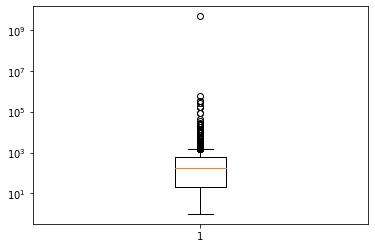

In [118]:
# your code here
# report the basic statistics of duration in 'validated' dataset
# boxplot code here
import numpy as np
import matplotlib.pyplot as plt

print("Max value of duration in (s) is : " +str(np.max(units))) 
print("Min value of duration in (s) is : " +str(np.min(units)))
print("Mean value of duration in (s) is : " +str(np.mean(units)))
print("Standard Deviation of duration in (s) is : " +str(np.std(units)))

boxp = plt.subplot()
boxp.boxplot(units)
boxp.set_yscale('log')
plt.show()





### (15pts) Part 1c: Can we do better?
Interesting. But we threw away a **lot** of data. We can do better. For this part, you will do your best to clean up the durations from your original dataset. Keep in mind some initial guidelines:

* If a duration has a range, use the average as its value. For example, if the duration is listed as “6-8 minutes”, you should consider the duration as “7 minutes”. (Again, you will need to eventually convert minutes into seconds).
* If a duration has a “<” sign, you should simply ignore the “<” sign. For example if the duration is specified as “< 1 minute”, consider the duration to be “1 minute”. You should subsequently convert “1 minute” to "60 seconds".
* If a duration has a “>” sign, you should simply ignore the “>” sign. 
* You should ignore any row with an empty duration.

You will probably have to improvise as you go along, so **make detailed notes of what decisions you are making and why**.

In [119]:
# your code here 
# clean data 
#/d includes all numbers starting from 0-9
#/s includes charecter with single space or more than single space
#\\< , \\~, \\> includes the durations starting with the symbols of <,> and ~
pattern1 = '^(\d+\s*(second|seconds|sec|secs|s|minute|minutes|min|mins|hour|hours|hr|hrs|day|days|week|weeks|month|months|year|years))$'
pattern2 = '^(\d+\\-\d+\s*(second|seconds|sec|secs|s|minute|minutes|min|mins|hour|hours|hr|hrs|day|days|week|weeks|month|months|year|years))$'
pattern3 = '^((\\<|\\~|\\>)\s*\d+\s*(second|seconds|sec|secs|s|minute|minutes|min|mins|hour|hours|hr|hrs|day|days|week|weeks|month|months|year|years))$'
pattern4 = '^(\\+\d+\s*(second|seconds|sec|secs|s|minute|minutes|min|mins|hour|hours|hr|hrs|day|days|week|weeks|month|months|year|years))$'


txufo2 = txufo.loc[txufo['Duration'].str.match(pattern1, na = False,flags = re.I) | txufo['Duration'].str.match(pattern2, na = False,flags = re.I) | txufo['Duration'].str.match(pattern3, na = False,flags = re.I)]

units2 =[]

#durations are converted into seconds
for i, row in txufo2.iterrows():
  row = txufo2['Duration'][i]
  num = re.findall('[0-9]+', row)
  num_list = [int (j) for j in num]
  val = np.mean(num_list)
  if(row.find("min")!= -1):
    val = val * 60
  elif(row.find("hour")!= -1):
    val = val * 3600
  elif(row.find("hr")!= -1):
    val = val * 3600
  elif(row.find("day")!= -1):
    val = val * 24 * 3600
  elif(row.find("week")!= -1):
    val = val * 7 * 24 * 3600
  elif(row.find("month")!= -1):
    val = val * 30 * 7 * 24 * 3600
  elif(row.find("year")!=-1):
    val = val * 12 * 30 * 7 * 24 * 3600
  
  
  units2.append(val)







In [120]:
# your code here
# total rows in original dataset
# valid rows in your cleaned dataset

total_rows = txufo.shape[0]
print("The total rows in original dataset is ",total_rows )
valid_rows = txufo2.shape[0]
print("The total rows in validated dataset is ",valid_rows )

The total rows in original dataset is  5631
The total rows in validated dataset is  4047


Max value of duration in (s) is : 1088640000.0
Min value of duration in (s) is : 1.0
Mean value of duration in (s) is : 270238.96540647396
Standard Deviation of duration in (s) is : 17110537.649616875


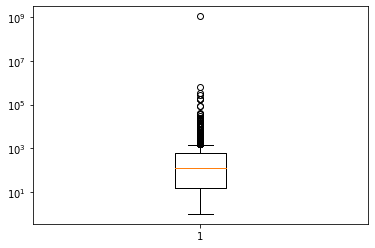

In [121]:
# your code here
# report the basic statistics of duration in your cleaned dataset
# draw a boxplot for your cleaned dataset

print("Max value of duration in (s) is : " +str(np.max(units2)))
print("Min value of duration in (s) is : " +str(np.min(units2)))
print("Mean value of duration in (s) is : " +str(np.mean(units2)))
print("Standard Deviation of duration in (s) is : " +str(np.std(units2)))

boxp2 = plt.subplot()
boxp2.boxplot(units2)
boxp2.set_yscale('log')
plt.show()


### (5pts) Part 1d: Observations and Conclusions

Based on your analysis on part 1b and 1c, what observations or conclusions can you make from the data?

1)Initially in part B, data is cleaned with strict restrictions where we have taken data with positive integers followed by space, followed by a properly spelled unit. 

2)Hence, we got only '2956' instances of sightings. 

3)Since, we felt that we threw away a lot of data, we leniently cleaned our data by allowing data in the form of numbers seperated with '-' and we also ignored rows with empty columns, < and > sign. 

4)In this case, we observed '4047' instances of sightings which is like 72% of our original data.

5)It has been observed that a lot of data was lost in the first approach of cleaning and second approach was much better in analyzing the data

6)More outliers can be observed in the second validated dataset. 

7)Mean is reduced in the second cleaning procedure where as standard deviation increased in the second cleaning method. 

8) Including more datapoints shifted the interquartile range down.

### (5pts) Part 1e: Next Steps

Now is your chance to conduct an interesting analysis on the UFO data you have collected. This is open-ended, so you may choose whatever direction you like. For example, you might want to take a look at the shape of the UFOs or perhaps the temporal aspects of the reports. 

In [61]:
# your code here
from collections import Counter
txufoshape = txufo['Shape']
txufocity = txufo['City']

print(Counter(txufoshape))
print(Counter(txufocity))
#we can observe that maximum people thought that the shape of ufo is light shaped and the second highest assumed shape of ufo is Triangle
#most ufo sightings are observed in Houston, Austin, Sn Antonio and Dallas. 
#We can see that mostly the sightings are from the big cities of Texas which might be due to high population in cities leading to more possible assumptions of sighting 

Counter({'Light': 1136, 'Triangle': 560, 'Circle': 520, 'Other': 440, 'Unknown': 427, 'Disk': 344, 'Sphere': 342, 'Fireball': 302, 'Oval': 299, 'Formation': 188, 'Cigar': 161, nan: 153, 'Changing': 151, 'Rectangle': 108, 'Cylinder': 94, 'Flash': 90, 'Diamond': 87, 'Chevron': 77, 'Teardrop': 61, 'Egg': 44, 'Cone': 19, 'Cross': 13, 'light': 5, 'triangle': 3, 'cigar': 2, 'other': 1, 'sphere': 1, 'diamond': 1, 'Delta': 1, 'rectangle': 1})
Counter({'Houston': 407, 'Austin': 324, 'San Antonio': 259, 'Dallas': 202, 'El Paso': 121, 'Fort Worth': 113, 'Corpus Christi': 79, 'Arlington': 79, 'Katy': 60, 'Plano': 59, 'Round Rock': 53, 'Lubbock': 51, 'Amarillo': 45, 'Abilene': 42, 'Garland': 40, 'Denton': 40, 'Spring': 39, 'Galveston': 34, 'San Angelo': 33, 'Irving': 31, 'McKinney': 31, 'Wichita Falls': 30, 'Odessa': 29, 'Lewisville': 29, 'Waco': 29, 'Georgetown': 28, 'Midland': 28, 'College Station': 28, 'San Marcos': 27, 'New Braunfels': 25, 'Mesquite': 24, 'Allen': 24, 'Richardson': 22, 'Bryan':

1)I have observed the shape of the UFOs and also the cities where sightings are observed

2)We can observe that maximum people thought that UFO appeared in the form of light and the second highest assumed shape of UFO is Triangle

3)Most UFO sightings are observed in Houston, Austin, Sn Antonio and Dallas. 

4)We can see that mostly the sightings are from the big cities of Texas which might be due to high population in cities leading to more possible assumptions of sighting **bold text**


## (50 points) Part 2: Association Rules in Movie Rating Behaviors

For the second part of this homework, we're going to examine movies using our understanding of association rules, to find movies that "go together". For this part, you will implement the apriori algorithm, and apply it to a movie rating dataset. We'll use the [MovieLens](https://grouplens.org/datasets/movielens/) dataset.

First, run the next cell to load the dataset we are going to use.

In [62]:
import urllib3
import zipfile

http = urllib3.PoolManager()
req = http.request("GET", "https://files.grouplens.org/datasets/movielens/ml-latest-small.zip", preload_content=False)

with open("movie.zip", 'wb') as out:
  while True:
    data = req.read(4096)
    if not data:
      break
    out.write(data)
req.release_conn()

zFile = zipfile.ZipFile("movie.zip", "r")
for fileM in zFile.namelist():
  zFile.extract(fileM)

/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


In [63]:
!ls ml-latest-small/

links.csv  movies.csv  ratings.csv  README.txt	tags.csv


In this dataset, there are four columns: `userId` is the integer ids of users, `movieId` is the integer ids of movies, `rating` is the rate of the user gives to the movie, and `timestamp` which we do not use here. Each row denotes that the user of given `userId` rated the movie of the given `movieId`. We are going to treat each user as a "basket", so you will need to collect all the movies that have been rated by a single user as a basket. 

Now, you need to implement the apriori algorithm and apply it to this dataset to find association rules of user rating behaviors where:

1. Define `rating` >= 3 is "like" (that is, only consider movie ratings of 3 or higher in your baskets; you may ignore all others)
2. `minsup` == 40 (out of 600 users/baskets); we may adjust this based on the discussion on Campuswire
3. `minconf` == to be determined by a discussion on Campuswire. You may try several different choices, but we will converge on a good choice for everyone for the final submission.
 
We know there are many existing implementations of apriori online (check github for some good starting points). You are welcome to read existing codebases and let that inform your approach. Do not copy-paste any existing code. We want your code to have sufficient comments to explain your steps, to show us that you really know what you are doing. Furthermore, you should add print statements to print out the intermediate steps of your method -- e.g., the size of the candidate set at each step of the method, the size of the filtered set, and any other important information you think will highlight the method. 

To help get you started, we can load the ratings with the following code snippet:

In [64]:
import pandas as pd
# read user ratings
allRatings = pd.read_csv("ml-latest-small/ratings.csv")
allRatings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


### (15pts) Step 1: Implement Apriori Algorithm
In this section, you need to implement the Apriori algorithm, we will check the correctness of your code and we encourage efficient implementation and skills of pruning.

In [65]:
#your code here
from numpy.ma.core import append
from collections import  defaultdict
from itertools import chain, combinations

#ignore movie ratings lessthan 3 and the dataset is modified
modifiedratings = allRatings[allRatings['rating']>=3]
df_movieratings = modifiedratings

#Group all the data with the help of userid
print("Data is grouped with the help of userId\n")
batch = df_movieratings.groupby('userId')
userId = batch.groups.keys()
movieId = []

#the itemset on which apriori can be implemented is created
for i in userId:
  movieId.append((batch.get_group(i).movieId.values))
modified_df = pd.DataFrame({'userId':userId, 'movieId' : movieId})


OriginalItemset = modified_df.movieId

print(modified_df)


#implement apriori function
#apriori takes the baskets as inputs and uses minsupport and minconf for pruning based on downward closure property
#alphafactor and minsup_samplefactor is used for sampling
#finally returns the frequent itemsets
def apriorialgo(Originallist, minsupport, minconf, alphafactor, minsup_samplefactor):
  freq = []
  oneitemset = set()
  for i in Originallist:
    for j in i:
      oneitemset.add(frozenset([j])) 

  a = str(len(oneitemset))
  print("\n There are a total of "+a+ " singleton itemsets in the dataset")

#to find the most frequent itemsets
#if the itemsets found lie above the support, they are taken as frequent itemsets
  def freqitemsets(itemset, Originallist, minsup, finalitemset):
    freq_itemset = set()
    d = defaultdict(int)
    for i in itemset:
      for itemset in Originallist:
        if i.issubset(itemset):
          finalitemset[i] += 1
          d[i] += 1
    for i, count in d.items():
      support = count
      if(support >= minsupport* minsup_samplefactor * alphafactor):
        freq_itemset.add(i)
    return freq_itemset
  
#pruning techniques used to remove the itemsets that are not currently in frequent itemlists
#all combinations of subsets for the itemsets are checked
  def pruning(futurecandidateset, presentfreqset, length):
    temp = futurecandidateset.copy()
    for i in futurecandidateset:
      subs = combinations(i,length)
      for s in subs:
        if(frozenset(s) not in presentfreqset):
          temp.remove(i)
          break
    return temp

#function to find association rules from the obtained itemset

  def association_rules(opfreqitemset, opitemsetwithsup, minconf):
    assoc_rules=[]
    for k,i in opfreqitemset.items():
      for j in i :
        subs = chain.from_iterable(combinations(j,l) for l in range(1, len(j)))
        for s in subs:
          confidence = float(opitemsetwithsup[j] / opitemsetwithsup[frozenset(s)])
          if(confidence >= minconf):
            assoc_rules.append([list(s) , list(j.difference(s))])

    return assoc_rules

  opitemsetwithsup = defaultdict(int)   
  opfreqitemset = dict()

  onefreqitemset = freqitemsets(oneitemset, Originallist, minsupport, opitemsetwithsup )
  presentfreqset = onefreqitemset
  freq = freq + list(presentfreqset)
    
  #to find 2 sized and more sized frequent itemsets
  k = 2

  while(presentfreqset):
    c = len(presentfreqset)
    print("\n"+str(k-1)+" sized itemsets with support greater than " +str(minsupport * alphafactor * minsup_samplefactor)+" are "+str(c)+"\n")
    opfreqitemset[k-1] = presentfreqset

    futurecandidateset = set([i.union(j) for i in presentfreqset for j in presentfreqset if len(i.union(j)) == k])
    futurecandidateset = pruning(futurecandidateset, presentfreqset, k-1)

    presentfreqset = freqitemsets(futurecandidateset, Originallist, minsupport, opitemsetwithsup)
    freq = freq + list(presentfreqset)
    k += 1

  assoc_rules = association_rules(opfreqitemset, opitemsetwithsup, minconf)
  print(opfreqitemset)
  return assoc_rules, opfreqitemset
    
assoc_rules, freq = apriorialgo(OriginalItemset, 150, 0.8, 1, 1)
print("The total no of association rules for the movielens dataset are "+str(len(assoc_rules)))

final_list = []
for i in list(freq.values()):
  final_list = final_list + list(i)


print("size of frequency itemset is obtained to be : " + str(len(final_list)))


#citations : https://towardsdatascience.com/apriori-association-rule-mining-explanation-and-python-implementation-290b42afdfc6
#https://japp.io/machine-learning/apriori-algorithm-program-in-python-from-scratch/
#https://github.com/chonyy/apriori_python

Data is grouped with the help of userId

     userId                                            movieId
0         1  [1, 3, 6, 47, 50, 70, 101, 110, 151, 157, 163,...
1         2  [318, 333, 1704, 3578, 6874, 8798, 46970, 4851...
2         3  [849, 1275, 1371, 1587, 2288, 2851, 3024, 3703...
3         4  [21, 45, 52, 58, 106, 125, 162, 171, 176, 215,...
4         5  [1, 21, 34, 36, 39, 50, 58, 110, 150, 153, 232...
..      ...                                                ...
604     606  [15, 17, 18, 28, 29, 32, 36, 46, 47, 50, 58, 6...
605     607  [1, 11, 25, 34, 36, 86, 110, 150, 153, 165, 18...
606     608  [10, 16, 21, 31, 32, 34, 39, 47, 50, 70, 104, ...
607     609  [1, 10, 110, 116, 137, 150, 161, 185, 208, 231...
608     610  [1, 6, 16, 32, 47, 50, 70, 95, 110, 111, 112, ...

[609 rows x 2 columns]

 There are a total of 8452 singleton itemsets in the dataset

1 sized itemsets with support greater than 150 are 37


2 sized itemsets with support greater than 150 are 30


3 si

### (5pts) Step 2: Print Your Association Rules

Next you should print your final association rules in the following format:

**movie_name_1, movie_name_2, ... --> 
movie_name_k**

where the movie names can be fetched by joining the movieId with the file `movies.csv`. For example, one rule that you might find is:

**Matrix, The (1999),  Star Wars: Episode V - The Empire Strikes Back (1980),  Star Wars: Episode IV - A New Hope (1977),  -> 
Star Wars: Episode VI - Return of the Jedi (1983)**

In [71]:
# your code here

movienames = pd.read_csv('/content/ml-latest-small/movies.csv')
movienames.head()

moviename = dict()
#association rules obtained are fetched along with the movieid
#all  association rules are printed in the required format of movie_name_i --> movie_name_j
for i in range(len(movienames)):
  moviename[movienames.loc[i,'movieId']] = movienames.loc[i, 'title']

def print_ar(assoc_rules):
  before =[]
  after =[]
  for i in assoc_rules:
    before.append(i[0])
    after.append(i[1])

  before_rules = []
  for i in before:
    check = []
    for j in range(0, len(i)):
      key = i[j]
      name_rule = moviename[(key)]
      check.append(moviename[(key)])

    before_rules.append(check)

  after_rules = []
  for i in after:
    check = []
    for j in range(0,len(i)):
      key = i[j]
      name_rule = moviename[(key)]
      check.append(name_rule)
    after_rules.append(check)

  rule = list(zip(before_rules, after_rules))
  final_rules = []
  for j in rule:
    final_rules.append(list(j))
  print("Following are the" +str(len(assoc_rules))+"Association rules \n")

  for i in final_rules:
    print(str(i[0])+"------> "+str((i[1])))


print_ar(assoc_rules)


Following are the14Association rules 

['Lord of the Rings: The Return of the King, The (2003)']------> ['Lord of the Rings: The Fellowship of the Ring, The (2001)']
['Lord of the Rings: The Fellowship of the Ring, The (2001)']------> ['Lord of the Rings: The Return of the King, The (2003)']
['Jurassic Park (1993)']------> ['Forrest Gump (1994)']
['Star Wars: Episode V - The Empire Strikes Back (1980)']------> ['Star Wars: Episode IV - A New Hope (1977)']
['Star Wars: Episode VI - Return of the Jedi (1983)']------> ['Star Wars: Episode IV - A New Hope (1977)']
['Lord of the Rings: The Two Towers, The (2002)']------> ['Lord of the Rings: The Fellowship of the Ring, The (2001)']
['Lord of the Rings: The Fellowship of the Ring, The (2001)']------> ['Lord of the Rings: The Two Towers, The (2002)']
['Star Wars: Episode VI - Return of the Jedi (1983)']------> ['Star Wars: Episode V - The Empire Strikes Back (1980)']
['Seven (a.k.a. Se7en) (1995)']------> ['Pulp Fiction (1994)']
['Lord of the

### (15pts) Step 3: Implement Random Sampling

We discussed in class a method to randomly sample baskets to avoid the overhead of reading the entire set of baskets (which in practice, could amount to billions of baskets). For this part, you should implement such a random sampling approach that takes a special parameter **alpha** that controls the size of the sample: e.g., alpha = 0.10 means to sample 10% of the baskets (our users, in this case). 

Vary **alpha** and report the number of frequent itemsets you find and how this compares to the number of frequent itemsets in the entire dataset. What do you discover?


In [95]:
#Alpha is varied between 0.3, 0.5 and 0.7

Itemsetsample4 = OriginalItemset.sample(frac=0.3)
Itemsetsample5 = OriginalItemset.sample(frac=0.5)
Itemsetsample6 = OriginalItemset.sample(frac=0.7)

#rules and freqitemsets are obtained
assoc_rules4, freq4 = apriorialgo(Itemsetsample4, 150, 0.9, 0.5, 1)
assoc_rules5, freq5 = apriorialgo(Itemsetsample5, 150, 0.9, 0.5, 1)
assoc_rules6, freq6 = apriorialgo(Itemsetsample6, 150, 0.9, 0.5, 1)

#count is obtained
freq4 = list(freq4.values())
freq5 = list(freq5.values())
freq6 = list(freq6.values())

list4 = []
for i in freq4:
  list4 = list4 + list(i)

list5 = []
for i in freq5:
  list5 = list5 + list(i)

list6 = []
for i in freq6:
  list6 = list6 + list(i)

print(len(final_list))
print(len(list4))
print(len(list5))
print(len(list6))


 There are a total of 4879 singleton itemsets in the dataset

1 sized itemsets with support greater than 75.0 are 4

{1: {frozenset({356}), frozenset({318}), frozenset({296}), frozenset({593})}}

 There are a total of 6615 singleton itemsets in the dataset

1 sized itemsets with support greater than 75.0 are 35


2 sized itemsets with support greater than 75.0 are 33


3 sized itemsets with support greater than 75.0 are 4

{1: {frozenset({32}), frozenset({1}), frozenset({380}), frozenset({150}), frozenset({1196}), frozenset({2959}), frozenset({480}), frozenset({7153}), frozenset({1270}), frozenset({1210}), frozenset({4993}), frozenset({1198}), frozenset({4306}), frozenset({2858}), frozenset({780}), frozenset({457}), frozenset({589}), frozenset({47}), frozenset({377}), frozenset({260}), frozenset({593}), frozenset({5952}), frozenset({588}), frozenset({592}), frozenset({364}), frozenset({318}), frozenset({2028}), frozenset({356}), frozenset({296}), frozenset({50}), frozenset({590}), fro

In [89]:
# your code here
import random

#50% sample of total data is taken
Itemsetsample1 = OriginalItemset.sample(frac=0.5)

#analyzed on various supports
assoc_rules1, freq1 = apriorialgo(Itemsetsample1, 150, 0.9, 0.5, 1)
assoc_rules2, freq2 = apriorialgo(Itemsetsample1, 150, 0.9, 0.7, 1)
assoc_rules3, freq3 = apriorialgo(Itemsetsample1, 150, 0.9, 0.9, 1)


#count is obtained
freq1 = list(freq1.values())
freq2 = list(freq2.values())
freq3 = list(freq3.values())

list1 = []
for i in freq1:
  list1 = list1 + list(i)

list2 = []
for i in freq2:
  list2 = list2 + list(i)

list3 = []
for i in freq3:
  list3 = list3 + list(i)

print(len(final_list))
print(len(list1))
print(len(list2))
print(len(list3))


 There are a total of 6247 singleton itemsets in the dataset

1 sized itemsets with support greater than 75.0 are 40


2 sized itemsets with support greater than 75.0 are 40


3 sized itemsets with support greater than 75.0 are 4

{1: {frozenset({1580}), frozenset({32}), frozenset({1}), frozenset({380}), frozenset({150}), frozenset({1196}), frozenset({2959}), frozenset({480}), frozenset({7153}), frozenset({4226}), frozenset({1270}), frozenset({1210}), frozenset({4993}), frozenset({3578}), frozenset({1198}), frozenset({2858}), frozenset({780}), frozenset({457}), frozenset({589}), frozenset({47}), frozenset({377}), frozenset({858}), frozenset({260}), frozenset({593}), frozenset({5952}), frozenset({588}), frozenset({592}), frozenset({364}), frozenset({318}), frozenset({2028}), frozenset({356}), frozenset({648}), frozenset({296}), frozenset({50}), frozenset({590}), frozenset({110}), frozenset({527}), frozenset({2762}), frozenset({608}), frozenset({2571})}, 2: {frozenset({296, 356}), froze


1)Initially, I have observed the frequent itemsets with various alpha values indicating samples of data of different sizes. Support is taken as same to observe trends.

2)499 frequent itemsets have been observed for 70% of the data with support of 75. Whereas 72 itemsers have been observed for 50% of the data and 4 itemsets have been observed for 30% of data with support of 75.

3)Hence, it can be observed that more frequent itemsets can be observed in large samples of data

4)I have also explored by checking a sample of data for different values of support.

5)I have taken 50% sample of the data and checked the frequent itemsets for different values of support.

6)For support with 75 we get 84 number of frequent itemsets. For support of 105 we get 13 number of frequent itemsets. For support with 135 we get 4 number of frequent itemsets

7) From this we can observe that, more number of itemsets can be observed with less support

### (10pts) Step 4: Check for False Positives

Next you should verify that the candidate pairs you discover by random sampling are truly frequent by comparing to the itemsets you discover over the entire dataset. 

For this part, consider another parameter **minsup_sample** that relaxes the minimum support threshold. For example if we want minsup = 1/100 for whole dataset, then try minsup_sample = 1/125 for the sample. This will help catch truly frequent itemsets.

Vary **minsup_sample** and report the number of frequent itemsets you find and the number of false positives you find. What do you discover?


In [97]:
# your code here
import random


assoc_rules7, freq7 = apriorialgo(Itemsetsample4, 150, 0.9, 0.3, 0.8)
assoc_rules8, freq8 = apriorialgo(Itemsetsample5, 150, 0.9, 0.5, 0.8)
assoc_rules9, freq9 = apriorialgo(Itemsetsample6, 150, 0.9, 0.7, 0.8)

freq7 = list(freq7.values())
freq8 = list(freq8.values())
freq9 = list(freq9.values())

list7 = []
for i in freq7:
  list7 = list7 + list(i)

list8 = []
for i in freq8:
  list8 = list8 + list(i)

list9 = []
for i in freq9:
  list9 = list9 + list(i)




 There are a total of 4879 singleton itemsets in the dataset

1 sized itemsets with support greater than 36.0 are 55


2 sized itemsets with support greater than 36.0 are 76


3 sized itemsets with support greater than 36.0 are 28


4 sized itemsets with support greater than 36.0 are 1

{1: {frozenset({1265}), frozenset({1580}), frozenset({32}), frozenset({10}), frozenset({1}), frozenset({380}), frozenset({1196}), frozenset({150}), frozenset({2959}), frozenset({1214}), frozenset({4995}), frozenset({1704}), frozenset({1291}), frozenset({480}), frozenset({7153}), frozenset({4226}), frozenset({1200}), frozenset({1210}), frozenset({1270}), frozenset({4993}), frozenset({3578}), frozenset({1198}), frozenset({4306}), frozenset({2858}), frozenset({58559}), frozenset({780}), frozenset({457}), frozenset({589}), frozenset({47}), frozenset({377}), frozenset({260}), frozenset({858}), frozenset({593}), frozenset({5952}), frozenset({588}), frozenset({318}), frozenset({364}), frozenset({592}), frozen

In [99]:
count4=0
count5=0
count6=0

#falsepositives are obtained for the samples of data

for i in (final_list):
  if i in list7:
    count4 = count4 + 1
print('When random sampling is done for 30% of data with minsupsample = 0.8, No of false positives are ' + str( len(list7)-count4))

for i in (final_list):
  if i in list8:
    count5 = count5 + 1
print('When random sampling is done for 50% of data with minsupsample = 0.8, No of false positives are ' + str( len(list8)-count5))

for i in (final_list):
  if i in list9:
    count6 = count6 + 1
print('When random sampling is done for 70% of data with minsupsample = 0.8, No of false positives are ' + str( len(list9)-count4))


When random sampling is done for 30% of data with minsupsample = 0.8, No of false positives are 92
When random sampling is done for 50% of data with minsupsample = 0.8, No of false positives are 169
When random sampling is done for 70% of data with minsupsample = 0.8, No of false positives are 178




1) It can be observed that we get 92 falsepositives for 30% of the data with minsup_sample as 0.8

2)It can be observed that we get 169 falsepositives for 50% of the data with minsup_sample as 0.8

3)It can be observed that we get 178 falsepositives for 70% of the data with minsup_sample as 0.8

4)From the above three observations, we can observe that, false positives increase when the sample size is large.

### (5pts) Step 5: Extensions and Next Steps

So far, we have been working with a fairly small dataset. For this last question, try your sampling-based approach on the much larger: **Movies 10M** dataset: https://files.grouplens.org/datasets/movielens/ml-10m.zip

First, we need to load this larger dataset:

In [100]:
import urllib3
import zipfile

http = urllib3.PoolManager()
req = http.request("GET", "https://files.grouplens.org/datasets/movielens/ml-10m.zip", preload_content=False)

with open("movie.zip", 'wb') as out:
  while True:
    data = req.read(4096)
    if not data:
      break
    out.write(data)
req.release_conn()

zFile = zipfile.ZipFile("movie.zip", "r")
for fileM in zFile.namelist():
  zFile.extract(fileM)

/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


In [101]:
! ls ml-10M100K/

allbut.pl  movies.dat  ratings.dat  README.html  split_ratings.sh  tags.dat


In [102]:
import pandas as pd
# read user ratings
allRatings = pd.read_csv("ml-10M100K/ratings.dat",sep='::', names=["userId", "movieId", "rating", "timestamp"], engine='python')
allRatings

,userId,movieId,rating,timestamp
0,1,122,5.0,838985046
1,1,185,5.0,838983525
2,1,231,5.0,838983392
3,1,292,5.0,838983421
4,1,316,5.0,838983392
...,...,...,...,...
10000049,71567,2107,1.0,912580553
10000050,71567,2126,2.0,912649143
10000051,71567,2294,5.0,912577968
10000052,71567,2338,2.0,912578016


Now you can begin your sampling over this larger dataset.

In [112]:
# your code here
modifiedratings = allRatings[allRatings['rating']>=3]
df_movieratings = modifiedratings

#Group all the data with the help of userid
print("Data is grouped with the help of userId\n")
batch = df_movieratings.groupby('userId')
userId = batch.groups.keys()
movieId = []

for i in userId:
  movieId.append((batch.get_group(i).movieId.values))
modified_df = pd.DataFrame({'userId':userId, 'movieId' : movieId})

OriginalItemset = modified_df.movieId

#hugedataset is sampled to a smalll chunk of data
OriginalItemset = OriginalItemset.sample(frac = 0.001)

assoc_rules, freq = apriorialgo(OriginalItemset, 20000, 0.8, 0.001,1)

final_list=[]
for i in list(freq.values()):
  final_list = final_list + list(i)

print(len(final_list))

Data is grouped with the help of userId


 There are a total of 2375 singleton itemsets in the dataset

1 sized itemsets with support greater than 20.0 are 28


2 sized itemsets with support greater than 20.0 are 7

{1: {frozenset({32}), frozenset({1}), frozenset({1196}), frozenset({2959}), frozenset({480}), frozenset({1210}), frozenset({1270}), frozenset({1198}), frozenset({780}), frozenset({589}), frozenset({47}), frozenset({377}), frozenset({260}), frozenset({858}), frozenset({593}), frozenset({318}), frozenset({592}), frozenset({2028}), frozenset({356}), frozenset({648}), frozenset({296}), frozenset({50}), frozenset({590}), frozenset({110}), frozenset({527}), frozenset({2762}), frozenset({608}), frozenset({2571})}, 2: {frozenset({296, 318}), frozenset({593, 356}), frozenset({296, 356}), frozenset({2571, 1196}), frozenset({296, 50}), frozenset({296, 593}), frozenset({2571, 260})}}
35


1) On the very huge dataset of 10M, Sample of 10000 is taken with a fraction of 0.001.

2)Support is taken as 20 and we obtained 35 frequent itemsets.